In [12]:
# from joblib import load
# from tqdm import tqdm

# true_prob = []
# size = 817
# with open('../../../../data/songda/truthful_qa/alpaca_7B_tqa_mc2_with_score.joblib', 'rb') as f:
#     for i in tqdm(range(size)):
#         try:
#             data = load(f)
#             true_prob.append(data['truth_prob'])
#         except EOFError:
#             break
    


# # Now 'data' contains the data loaded from the file
# count = 0
# for i in range(len(true_prob)):
#     if true_prob[i] > 0.5:
#         count += 1
# print(count)




In [13]:
import pickle
from sklearn.model_selection import train_test_split

def load_lists(filename):
    with open(filename, 'rb') as f:
        list1, list2, list3 = pickle.load(f)
    return list1, list2, list3


loaded_list1, loaded_list2, loaded_list3 = load_lists('attention_GMM_150_1024.pkl')
print("Loaded list1:",  len(loaded_list1), len(loaded_list1[0])/32)
print("Loaded list2:", len(loaded_list2))

print(sum(len(sublist) for sublist in loaded_list1))


Loaded list1: 817 2.15625
Loaded list2: 817
46749


In [14]:
import pandas as pd
import numpy as np

def extract_features(arr):
    # Feature extraction for each array
    mean = np.mean(arr)
    std = np.std(arr)
    max_value = np.max(arr)
    min_value = np.min(arr)
    # ... add any other features you find useful

    return [mean, std, max_value, min_value]

# Extract features from each array and convert to pandas DataFrame
features = np.array([extract_features(arr) for arr in loaded_list1])
df = pd.DataFrame(features, columns=['mean', 'std', 'max', 'min'])
df['label'] = loaded_list2

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('label', axis=1), df['label'], test_size=0.2, random_state=42)

# Initialize and train classifier
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Evaluate classifier
score = classifier.score(X_test, y_test)
print(f"Test accuracy: {score * 100}%")


Test accuracy: 57.92682926829268%


In [16]:
# Creating and training a Random Forest Classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)

# Predicting on the testing set
y_pred = classifier.predict(X_test)
print(y_pred)
print("Accuracy: ", accuracy_score(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix: \n{conf_matrix}')



[0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 1 0 1
 0 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0 1 0 1 1 0 1 0 0 1 1 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 1 1 1 0 1 1 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0
 0 0 1 0 0 1 0 0 0 0 1 1 0 0 1 0]
Accuracy:  0.6097560975609756
Confusion Matrix: 
[[72 20]
 [44 28]]


In [17]:
from collections import Counter

def eval(list_of_arrays, list_of_results):
    state_statics = {}
    # Iterate over the list_of_arrays and list_of_results
    for i in range(len(list_of_arrays)):
        # Get the array and corresponding result
        unique_array = set(list_of_arrays[i])
        result = list_of_results[i]
        for one_state in unique_array:
            if one_state not in state_statics:
                state_statics[one_state] = {'truth': 0, 'fake': 0}
            if result == 1:
                state_statics[one_state]['truth'] += 1
            else: 
                state_statics[one_state]['fake'] += 1

    fake_representation_prob = {}

    for one_state in state_statics:
        all_count = state_statics[one_state]["truth"] + state_statics[one_state]["fake"]
        prob = state_statics[one_state]["fake"] * 1. / all_count
        
        fake_representation_prob[one_state] = prob
    return fake_representation_prob, state_statics

fake_probs, state_statics = eval(loaded_list1, loaded_list2)


keys_greater_than_0_6 = [key for key, value in fake_probs.items() if value > 0.6]
keys_greater_than_0_7 = [key for key, value in fake_probs.items() if value > 0.7]
keys_greater_than_0_8 = [key for key, value in fake_probs.items() if value > 0.8]
keys_greater_than_0_9 = [key for key, value in fake_probs.items() if value > 0.9]
keys_equal_1 = [key for key, value in fake_probs.items() if value == 1]

print(len(keys_greater_than_0_6) / 100, keys_greater_than_0_6)
print(len(keys_greater_than_0_7) / 100, keys_greater_than_0_7)
print(len(keys_greater_than_0_8) / 100, keys_greater_than_0_8)
print(len(keys_greater_than_0_9) / 100, keys_greater_than_0_9)
print(len(keys_equal_1) / 100, keys_equal_1)



0.37 [18, 36, 74, 40, 56, 82, 2, 4, 48, 35, 70, 14, 37, 6, 87, 60, 23, 63, 67, 10, 27, 75, 20, 71, 76, 49, 28, 29, 59, 86, 13, 95, 90, 25, 53, 97, 61]
0.18 [40, 48, 6, 60, 10, 20, 71, 76, 28, 29, 59, 86, 13, 90, 25, 53, 97, 61]
0.12 [40, 6, 20, 76, 28, 59, 86, 90, 25, 53, 97, 61]
0.08 [40, 76, 28, 59, 25, 53, 97, 61]
0.08 [40, 76, 28, 59, 25, 53, 97, 61]


In [18]:
percentage_threshold = 0.9
all_counts = 0
fake_counts_in_truth = 0
fake_counts_in_fake = 0
for i, sentence in enumerate(loaded_list1):
    is_exist = False
    for j in range(len(sentence)):
        if fake_probs[sentence[j]] > percentage_threshold:
            if loaded_list2[i] == 1:
                fake_counts_in_truth += 1
            else:
                fake_counts_in_fake += 1
        all_counts += 1

        
    # else:
    #     print("============EXCEPTION============")
print(fake_counts_in_truth, fake_counts_in_fake, fake_counts_in_truth / all_counts, fake_counts_in_fake / all_counts)

0 1248 0.0 0.02669575819803632


In [19]:
percentage_result = []
for sentence in loaded_list1:
    # Map the sentence tokens to their fake probabilities
    sentence_probs = [fake_probs[token] for token in sentence]

    # Calculate the mean fake probability for the sentence
    mean_prob = sum(sentence_probs) / len(sentence_probs)

    # Classify the sentence as fake if mean_prob > 0.5, true otherwise
    percentage_result.append(mean_prob * (-1))


# ROC AUC Score

fpr, tpr, thresholds = roc_curve(loaded_list2, percentage_result)
print(f'ROC AUC Score: {auc(fpr, tpr)}')

ROC AUC Score: 0.7318715101323797


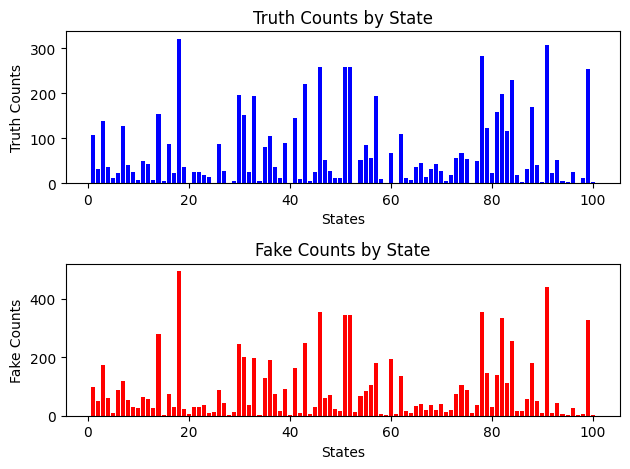

In [22]:
import matplotlib.pyplot as plt
# Separating the states, truth and fake counts into separate lists
states = list(state_statics.keys())
truth_counts = [state_statics[state]['truth'] for state in states]
fake_counts = [state_statics[state]['fake'] for state in states]

# Creating the bar charts
fig, axs = plt.subplots(2)

# Bar chart for 'truth' counts
axs[0].bar(states, truth_counts, color='b')
axs[0].set_title('Truth Counts by State')
axs[0].set_xlabel('States')
axs[0].set_ylabel('Truth Counts')

# Bar chart for 'fake' counts
axs[1].bar(states, fake_counts, color='r')
axs[1].set_title('Fake Counts by State')
axs[1].set_xlabel('States')
axs[1].set_ylabel('Fake Counts')

# Automatically adjust the subplot layout
fig.tight_layout()

plt.show()